# Computational Replication of Essential Gene Identification Methods in Targeted Genome Sequencing
### Project submitted for the final exam of the Artificial Intelligence course - B003725

**Author:** Niccolò Caselli


Importing the Required Libraries:

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Constants and the CMIM (Conditional Mutual Information Maximization) ranking for the groups of features:

In [62]:
PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']


CIMIM_EC_GENPROT = [
    "phyletic_retention", "Ser", "Trp", "paralog_count", "Leu", "orf_size", 
    "Thr", "Cys", "Gln", "Phe", "Pro", "CAI", "Ile", "Tyr", "His", 
    "Asn", "strand_bias", "Gly", "Asp", "Fop", "Aromaticity", "Val", "Ala", 
    "Lys", "Glu", "CBI", "Met", "Arg"
]

CIMIM_EC_NO_GENPROT = [
    "Ser", "CAI", "Trp", "paralog_count", "Leu", "orf_size", "strand_bias", 
    "Thr", "Cys", "Gln", "Phe", "Pro", "Ile", "Tyr", "His", "Asn", "Gly", 
    "Asp", "Fop", "Aromaticity", "Val", "Ala", "Lys", "Glu", "CBI", "Met", "Arg"
]

## `EssentiallyClassifier` Class

The `EssentiallyClassifier` class is an abstract base class designed to be implemented by different classifiers algorithms provviding a common interface for all classifiers.

It includes methods for finding the optimal number of features, calculating the PPV for the percentiles, and plotting the ROC curve and the PPV graph.

In [63]:

class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """

    def __init__(self, file_path, cmim_ranking, percentiles,name, skip_discretization=False):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None # Features
        self.y = None # Labels of Grand truth
        self.optimal_features = None # Optimal number of features to use
        self.highest_ppv_5 = 0 # Highest PPV (5%), used to find optimal number of features 
        self.final_ppv_scores = [] # Final PPV scores for the top percentiles
        self.final_fpr = [] # Final FPR scores
        self.final_tpr = [] # Final TPR scores
        self.final_auc = None # Final AUC score
        self.categories = None # Number of unique categories in the data
        self.skip_discretization = skip_discretization # Load the data without discretization


    def load_data(self):
        """
        Loads the data with the specified method.
        """
        self.load_discretized_data() if not self.skip_discretization else self.load_raw_data()

        # Count how many essential and non-essential genes there are
        print("Essential genes:", np.sum(self.y), "Non-essential genes:", len(self.y) - np.sum(self.y), "Essential ratio:", np.sum(self.y) / len(self.y))


    def load_raw_data(self):
        """
        Loads the data without discretization.
        """
        data = pd.read_excel(self.file_path, sheet_name='raw data')
        self.X = data.drop(columns=['Essential', 'orf_id'])
        self.y = data['Essential']
        print("Row data loaded successfully, shape:", self.X.shape, self.y.shape)

    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        Counts the number of unique categories in the data.
        """
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        # Count the number of unique categories in the data
        min_categories = self.X.nunique()
        self.categories = min_categories  

        print("Discretized data loaded successfully, shape:", self.X.shape, self.y.shape)
        #self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)


    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number 
        of features taken ordered by CMIM ranking.
        """

        # Only features of the specific feature set 
        X_ranked = self.X[self.cmim_ranking]

        print("Starting to find optimal number of features...")

        min_features = 2

        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), min_features, -1):
            X_selected = X_ranked.iloc[:, :i]

            # Evaluate the model with the selected features
            res = self.evaluate_model(X_selected)
            ppv = res[0]
            
            ppv_1 = ppv[0] # PPV (1%)
            ppv_5 = ppv[1] # PPV (5%)
            print(f"Features: {i}, PPV (1%): {ppv_1}, PPV (5%): {ppv_5}")

            # Update the highest PPV (5%) and optimal number of features
            if ppv_5 > self.highest_ppv_5 and ppv_1 >= ppv_5:
                self.highest_ppv_5 = ppv_5
                self.optimal_features = i

        # Print the results
        print("Highest PPV (5%):", self.highest_ppv_5)
        print("Optimal number of features:", self.optimal_features, self.cmim_ranking[:self.optimal_features])



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores, self.final_fpr, self.final_tpr, self.final_auc = self.evaluate_model(X_optimal)
    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(6, 4))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()


    def plot_final_roc_curve(self):
        """
        Plot the final ROC curve for the classifier.
        """
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(self.final_fpr, self.final_tpr, color='blue', label=self.name + f' (AUC = {self.final_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for {self.name}')
        ax.legend()
        fig.tight_layout()
        plt.show()
        


    def run(self):
        """
        Build and evaluate the classifier.
        """

        self.load_data()
        self.find_optimal_features() 
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)
        self.plot_final_roc_curve()



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.
        - FPR values for the final ROC curve.
        - TPR values for the final ROC curve.
        - AUC score for the final ROC curve.

        To be implemented by the subclass.
        """
        pass


## `EssentiallyBayesClassifier` Class

The `EssentiallyBayesClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It utilizes a Naive Bayes classifier to perform essentiality prediction tasks. 
The implementation uses the boostrapping technique.


In [64]:
class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes Classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
            - FPR values of various percentiles
            - TPR values of various percentiles
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        selected_categories = self.categories[X_selected.columns].to_numpy()

        nb_classifier = CategoricalNB(min_categories=selected_categories)
        nb_classifier.fit(X_train, y_train)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]
     
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy()), fpr, tpr, auc


    # Override 
    def evaluate_model(self, X_selected):
        all_ppv = []
        all_tpr = []
        all_auc = []
        mean_fpr = np.linspace(0,1,100)

        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration, fpr_iteration, tpr_iteration, auc_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppv.append(ppv_iteration)
            all_tpr.append(np.interp(mean_fpr, fpr_iteration, tpr_iteration))
            all_auc.append(auc_iteration)

        # Calculate the mean PPV, FPR, TPR and AUC
        mean_ppv = np.mean(all_ppv, axis=0)
        mean_tpr = np.mean(all_tpr, axis=0)
        mean_auc = np.mean(all_auc)

        return mean_ppv, mean_fpr, mean_tpr, mean_auc

## `EssentialityExperiment` Class

The `EssentialityExperiment` class is designed to manage, run and compare multiple classifiers.
It inclueds methods for executing experiments, visualizing comparative tables and plots.


In [65]:
class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_and_save_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors 

        fig, ax = plt.subplots(figsize=(6, 4))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Save the plot to a file
        #fig.savefig(f'./output/{self.name}_ppv_plot.png')


    def plot_and_save_comparative_table(self, colors=COLORS):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        _colors = [f'{color}50' for color in colors]  # Add alpha chanel to colors
        color_map = {classifier.name: _colors[i % len(_colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')


        # Save the table to a CSV file
        #table_df.to_csv(f'./output/{self.name}_ppv_table.csv')


        return styled_df


# S. cerevisiae
### Running the Experiment with Naive Bayes for S. cerevisiae

Let's begin with classification for *S. cerevisiae* using the three feature groups and the Naive Bayes algorithm.

The groups are defined as follows:

- **SC_GenProt**: Composed of all features that can be obtained directly from sequenced data.
- **SC_GenProt_No**: Similar to **SC_GenProt**, but excluding the phyletic retention measure.
- **SC_All**: Composed of features that require extensive experimentation in addition to the easily obtainable features.

These classifiers will be evaluated and compared in the experiment, comparing their performance with the PPV metric and plotting their ROC curves.


--------------------------------------------------------------------------------
Running experiment for S. cerevisiae - Naive Bayes
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Essential genes: 966 Non-essential genes: 3762 Essential ratio: 0.20431472081218274
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9186956521739136, PPV (5%): 0.758220338983051
Features: 41, PPV (1%): 0.9182608695652179, PPV (5%): 0.7600000000000001
Features: 40, PPV (1%): 0.9221739130434794, PPV (5%): 0.7625423728813562
Features: 39, PPV (1%): 0.92, PPV (5%): 0.754830508474576
Features: 38, PPV (1%): 0.9156521739130439, PPV (5%): 0.755593220338983
Features: 37, PPV (1%): 0.9182608695652178, PPV (5%): 0.7566101694915249
Features: 36, PPV (1%): 0.917391304347

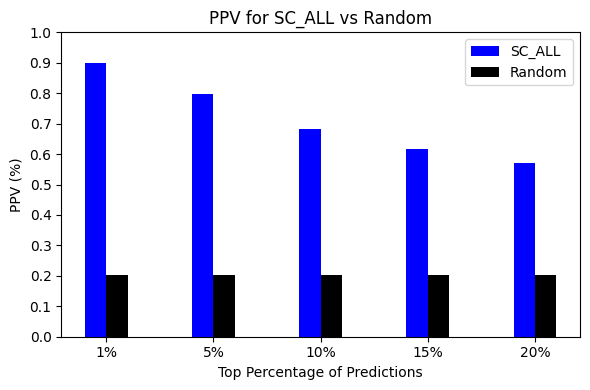

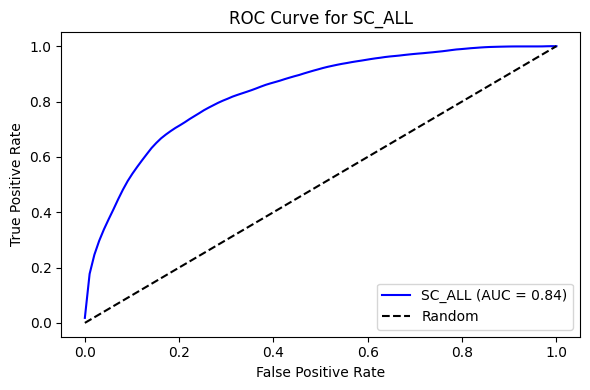

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Essential genes: 966 Non-essential genes: 3762 Essential ratio: 0.20431472081218274
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8213043478260867, PPV (5%): 0.6615254237288134
Features: 15, PPV (1%): 0.8156521739130433, PPV (5%): 0.6770338983050849
Features: 14, PPV (1%): 0.816086956521739, PPV (5%): 0.6630508474576273
Features: 13, PPV (1%): 0.8234782608695645, PPV (5%): 0.6769491525423732
Features: 12, PPV (1%): 0.8239130434782607, PPV (5%): 0.6935593220338983
Features: 11, PPV (1%): 0.8430434782608691, PPV (5%): 0.7180508474576272
Features: 10, PPV (1%): 0.834347826086956, PPV (5%): 0.7138983050847455
Features: 9, PPV (1%): 0.8717391304347819, PPV (5%): 0.7034745762711863
Features: 8, PPV (1%): 0.8465217391304344, PPV (5%): 0.6979661016949155
Features: 7, PPV (1%): 0.8213043478260864, PPV (5%): 0.6889830508474578

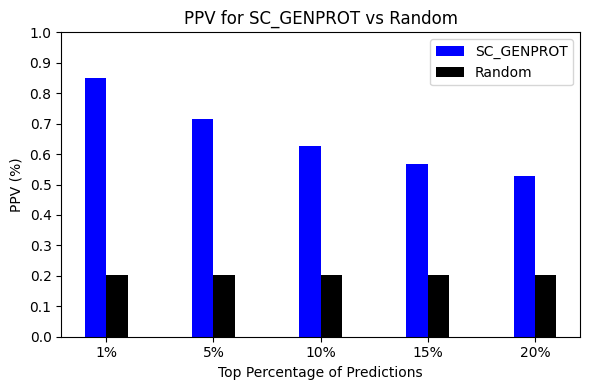

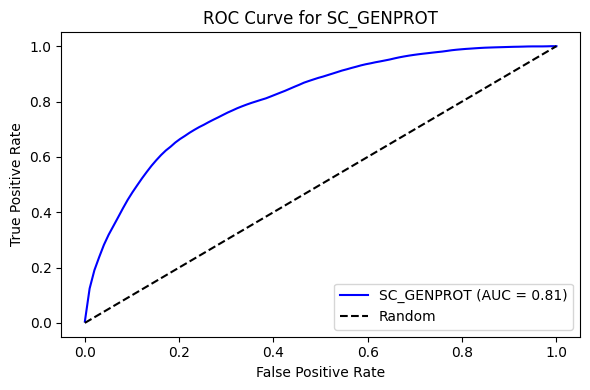

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Essential genes: 966 Non-essential genes: 3762 Essential ratio: 0.20431472081218274
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.657826086956522, PPV (5%): 0.5159322033898305
Features: 14, PPV (1%): 0.5956521739130439, PPV (5%): 0.5087288135593218
Features: 13, PPV (1%): 0.6160869565217394, PPV (5%): 0.519491525423729
Features: 12, PPV (1%): 0.5639130434782609, PPV (5%): 0.44550847457627113
Features: 11, PPV (1%): 0.5604347826086958, PPV (5%): 0.4551694915254236
Features: 10, PPV (1%): 0.5313043478260869, PPV (5%): 0.4569491525423727
Features: 9, PPV (1%): 0.46869565217391307, PPV (5%): 0.5040677966101696
Features: 8, PPV (1%): 0.46565217391304337, PPV (5%): 0.5031355932203389
Features: 7, PPV (1%): 0.513478260869565, PPV (5%): 0.5235593220338982
Features: 6, PPV (1%): 0.5343478260869569, PPV (5%): 0.535508474576

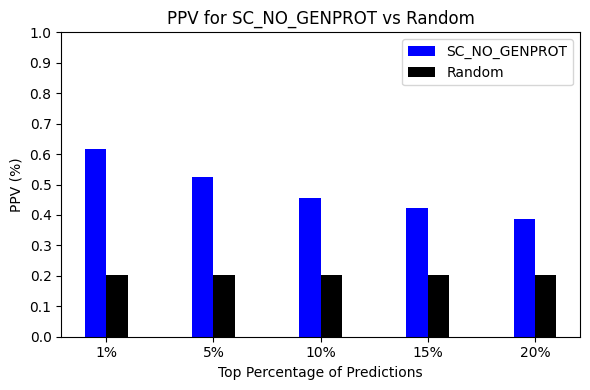

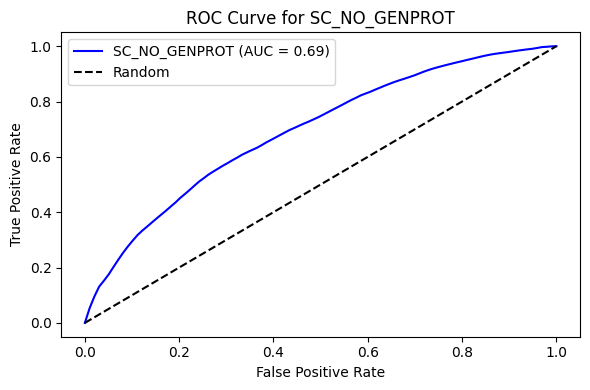

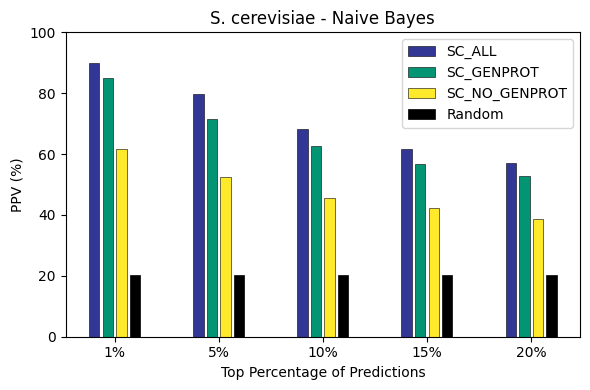

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.9,0.8,0.68,0.62,0.57,23
SC_GENPROT,0.85,0.71,0.63,0.57,0.53,11
SC_NO_GENPROT,0.62,0.53,0.45,0.42,0.39,13


In [66]:
classifier_no_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_nb = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae - Naive Bayes", [classifier_all_nb, classifier_genprot_nb, classifier_no_genprot_nb])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_and_save_comparative_table()

## `EssentialityRandomForestClassifier` Class

The `EssentialityRandomForestClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It leverages the Random Forest classifier to perform essentiality prediction tasks. 

This implementation utilizes the k-fold cross-validation technique to evaluate the model's performance.

We can use this classifier to compare the performance of the Random Forest algorithm with the Naive Bayes algorithm.


In [95]:
class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles, name, skip_discretization=False)
        self.rf_classifiers = []  # List of Random Forest classifiers for each fold

   
    # Override
    def evaluate_model(self, X_selected):
        self.rf_classifiers = []  # Reset the list of classifiers

        k_folds = 5  # Number of folds
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)


        all_ppv = []
        all_tpr = []
        all_auc = []
        mean_fpr = np.linspace(0,1,100)

        for train_index, test_index in skf.split(X_selected, self.y):
            X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            # Build and fit the Random Forest classifier
            rf_classifier = RandomForestClassifier(
                n_estimators=100,           # Number of trees
                max_depth=15,               # Maximum depth of the tree
                min_samples_leaf=5,         # Minimum samples per leaf 
                max_features='sqrt',        # Features considered for best split
                class_weight='balanced',    # Handle imbalanced classes
                n_jobs=-1                   # Use all cores 
            )
            rf_classifier.fit(X_train, y_train)

            # Predict probabilities on the test set
            y_prob = rf_classifier.predict_proba(X_test)[:, 1]

            # Calculate metrics
            ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            

            all_ppv.append(ppv_iteration)
            all_tpr.append(np.interp(mean_fpr, fpr, tpr))
            all_auc.append(auc)

            # Save the classifier 
            self.rf_classifiers.append(rf_classifier)
        
        
        mean_ppv = np.mean(all_ppv, axis=0)
        mean_tpr = np.mean(all_tpr, axis=0)
        mean_auc = np.mean(all_auc)


        return mean_ppv, mean_fpr, mean_tpr, mean_auc
    

    def plot_feature_importance(self):
        """
        Plot the feature importance of the Random Forest classifier.
        """

        all_importances = [clf.feature_importances_ for clf in self.rf_classifiers]
        importances = np.mean(all_importances, axis=0)  
        feature_names = self.X[self.cmim_ranking].iloc[:, :self.optimal_features].columns

        plt.figure(figsize=(9, 6)) 
        plt.bar(feature_names, importances)
        plt.ylabel("Feature Importance")
        plt.xlabel("Feature")
        plt.title(f"Feature Importance in Random Forest for {self.name}")
        plt.xticks(rotation=90, ha='center', fontsize=9)
        plt.tight_layout()
        plt.show()

    # Extend the run method to plot feature importance
    def run(self):
        super().run()
        self.plot_feature_importance()

### Running the Experiment with Random Forest for S. cerevisiae

So now we can run the experiment for *S. cerevisiae* using the Random Forest algorithm for the three feature groups.

--------------------------------------------------------------------------------
Running experiment for S. cerevisiae - Random Forest
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Essential genes: 966 Non-essential genes: 3762 Essential ratio: 0.20431472081218274
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.888888888888889, PPV (5%): 0.8085106382978722
Features: 41, PPV (1%): 0.888888888888889, PPV (5%): 0.8212765957446809
Features: 40, PPV (1%): 0.888888888888889, PPV (5%): 0.8212765957446807
Features: 39, PPV (1%): 0.9333333333333332, PPV (5%): 0.8085106382978724
Features: 38, PPV (1%): 0.9333333333333332, PPV (5%): 0.8212765957446807
Features: 37, PPV (1%): 0.9111111111111111, PPV (5%): 0.8042553191489361
Features: 36, PPV (1%)

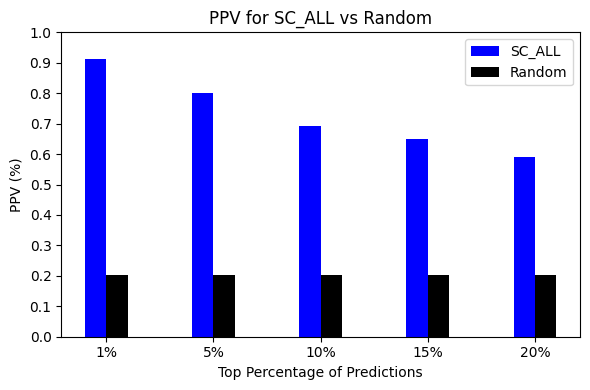

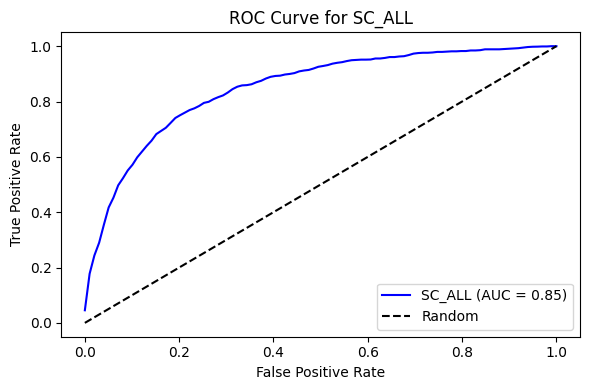

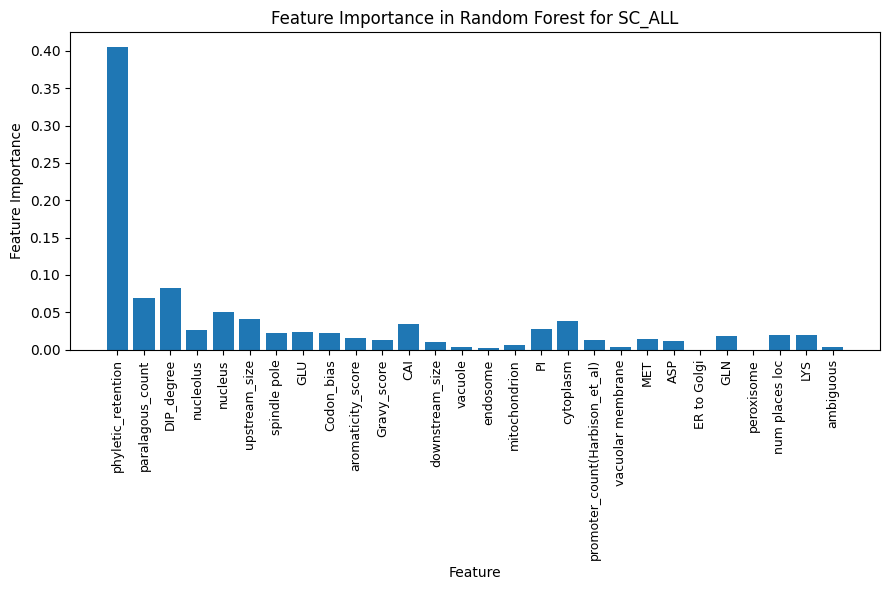

Running classifier SC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Essential genes: 966 Non-essential genes: 3762 Essential ratio: 0.20431472081218274
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.8444444444444444, PPV (5%): 0.727659574468085
Features: 15, PPV (1%): 0.8, PPV (5%): 0.7148936170212765
Features: 14, PPV (1%): 0.8222222222222222, PPV (5%): 0.6978723404255319
Features: 13, PPV (1%): 0.9111111111111111, PPV (5%): 0.7148936170212765
Features: 12, PPV (1%): 0.8444444444444444, PPV (5%): 0.7021276595744681
Features: 11, PPV (1%): 0.8666666666666666, PPV (5%): 0.7063829787234042
Features: 10, PPV (1%): 0.8666666666666666, PPV (5%): 0.727659574468085
Features: 9, PPV (1%): 0.8666666666666666, PPV (5%): 0.7404255319148936
Features: 8, PPV (1%): 0.8444444444444443, PPV (5%): 0.7319148936170212
Features: 7, PPV (1%): 0.7777777777777778, PPV (5%): 0.7319148936170213
Features: 6, P

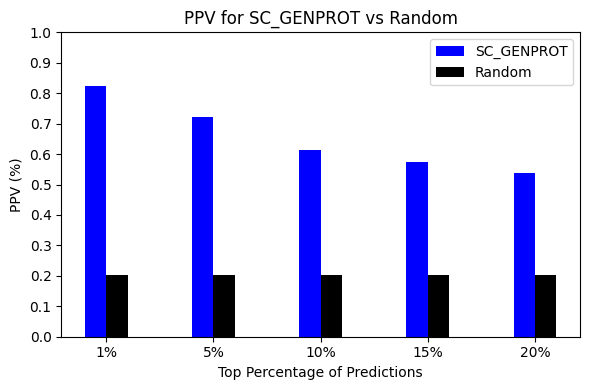

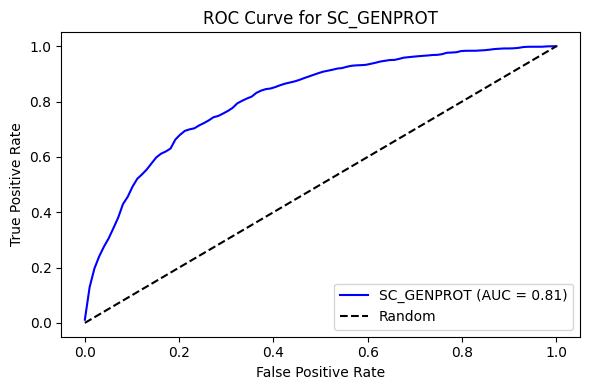

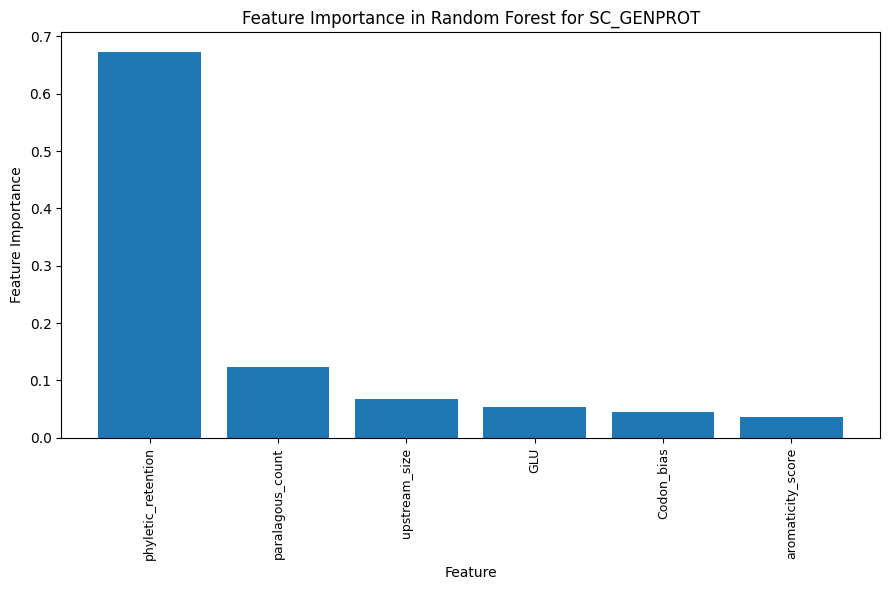

Running classifier SC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (4728, 42) (4728,)
Essential genes: 966 Non-essential genes: 3762 Essential ratio: 0.20431472081218274
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.6222222222222222, PPV (5%): 0.5148936170212766
Features: 14, PPV (1%): 0.6222222222222222, PPV (5%): 0.553191489361702
Features: 13, PPV (1%): 0.5333333333333333, PPV (5%): 0.5446808510638299
Features: 12, PPV (1%): 0.5111111111111111, PPV (5%): 0.5063829787234042
Features: 11, PPV (1%): 0.6666666666666666, PPV (5%): 0.5319148936170213
Features: 10, PPV (1%): 0.6888888888888889, PPV (5%): 0.5404255319148936
Features: 9, PPV (1%): 0.711111111111111, PPV (5%): 0.5234042553191489
Features: 8, PPV (1%): 0.6, PPV (5%): 0.5404255319148936
Features: 7, PPV (1%): 0.6666666666666666, PPV (5%): 0.5063829787234042
Features: 6, PPV (1%): 0.6444444444444445, PPV (5%): 0.5234042553191489
Features: 5,

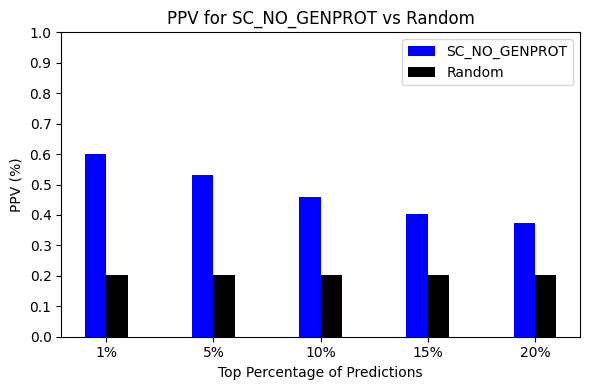

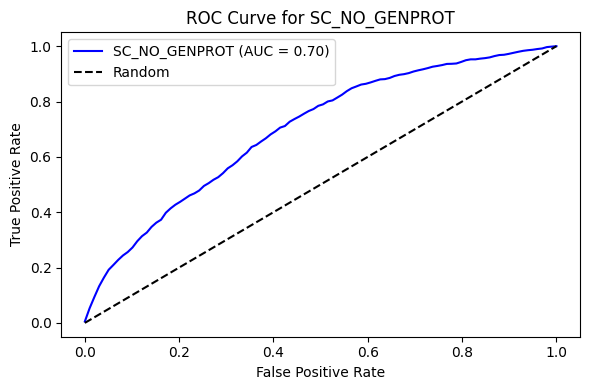

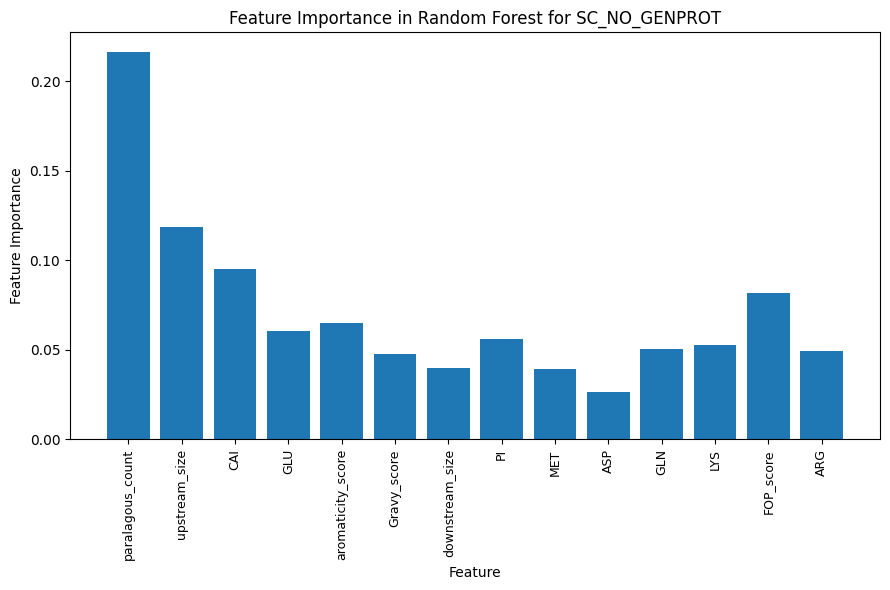

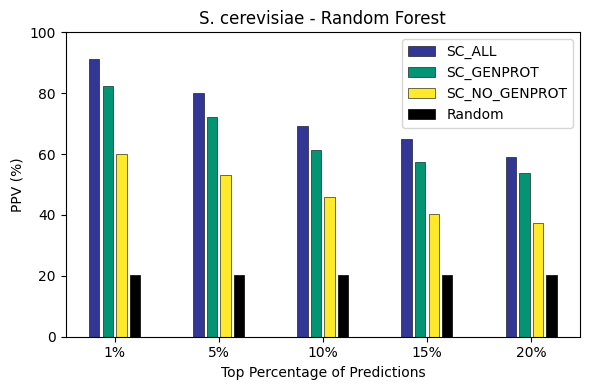

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.91,0.8,0.69,0.65,0.59,28
SC_GENPROT,0.82,0.72,0.61,0.57,0.54,6
SC_NO_GENPROT,0.6,0.53,0.46,0.4,0.37,14


In [103]:
classifier_no_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all_rf = EssentialityRandomForestClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae - Random Forest", [classifier_all_rf, classifier_genprot_rf, classifier_no_genprot_rf])

experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])
experiment.plot_and_save_comparative_table()

### Compare ROC Curves of Naive Bayes and Random Forest for SC_ALL

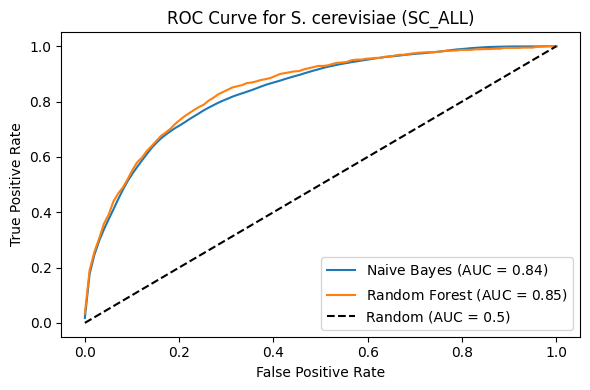

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(classifier_all_nb.final_fpr, classifier_all_nb.final_tpr, label='Naive Bayes (AUC = ${:.2f}$)'.format(classifier_all_nb.final_auc))
ax.plot(classifier_all_rf.final_fpr, classifier_all_rf.final_tpr, label='Random Forest (AUC = ${:.2f}$)'.format(classifier_all_rf.final_auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for S. cerevisiae (SC_ALL)')
ax.legend()
fig.tight_layout()


# Escherichia Coli

### Running the Experiment with Naive Bayes Classifier for E. coli

In this section, we are running an experiment using the `EssentiallyBayesClassifier` with two different feature groups for *E. coli*. The groups are defined as follows:

- **EC_GenProt**: Composed of all features that can be obtained directly from sequenced data.
- **EC_GenProt_No**: Similar to **EC_GenProt**, but excluding the phyletic retention measure.

--------------------------------------------------------------------------------
Running experiment for E. coli - Naive Bayes
Classifiers:  ['EC_GENPROT', 'EC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier EC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Essential genes: 611 Non-essential genes: 2958 Essential ratio: 0.17119641356122164
Starting to find optimal number of features...
Features: 28, PPV (1%): 0.7799999999999998, PPV (5%): 0.462247191011236
Features: 27, PPV (1%): 0.7970588235294117, PPV (5%): 0.46550561797752843
Features: 26, PPV (1%): 0.8082352941176467, PPV (5%): 0.46382022471910117
Features: 25, PPV (1%): 0.7905882352941171, PPV (5%): 0.4539325842696631
Features: 24, PPV (1%): 0.8005882352941169, PPV (5%): 0.4542696629213485
Features: 23, PPV (1%): 0.8082352941176463, PPV (5%): 0.45483146067415753
Features: 22, PPV (1%): 0.78764

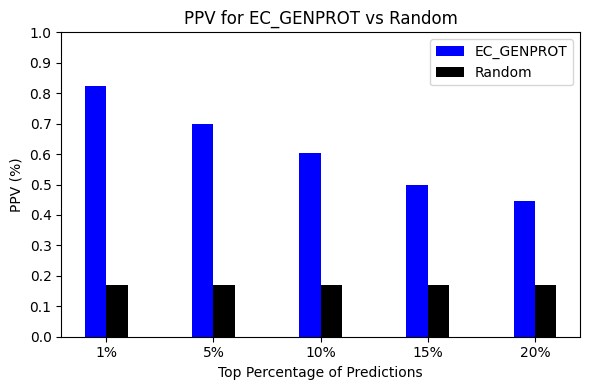

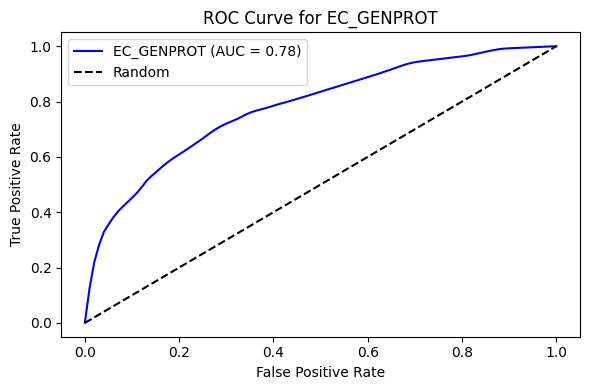

Running classifier EC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Essential genes: 611 Non-essential genes: 2958 Essential ratio: 0.17119641356122164
Starting to find optimal number of features...
Features: 27, PPV (1%): 0.6835294117647055, PPV (5%): 0.3946067415730337
Features: 26, PPV (1%): 0.7276470588235291, PPV (5%): 0.41101123595505595
Features: 25, PPV (1%): 0.7158823529411762, PPV (5%): 0.4031460674157304
Features: 24, PPV (1%): 0.7258823529411762, PPV (5%): 0.39629213483146075
Features: 23, PPV (1%): 0.74, PPV (5%): 0.41101123595505606
Features: 22, PPV (1%): 0.7564705882352937, PPV (5%): 0.40977528089887644
Features: 21, PPV (1%): 0.7452941176470581, PPV (5%): 0.4110112359550561
Features: 20, PPV (1%): 0.7388235294117643, PPV (5%): 0.4237078651685393
Features: 19, PPV (1%): 0.7388235294117642, PPV (5%): 0.42820224719101124
Features: 18, PPV (1%): 0.7099999999999995, PPV (5%): 0.414494382022472
F

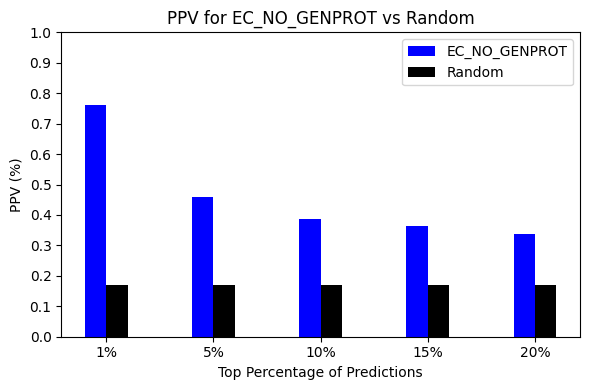

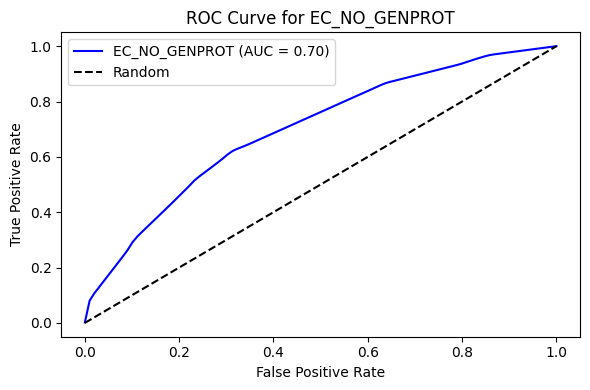

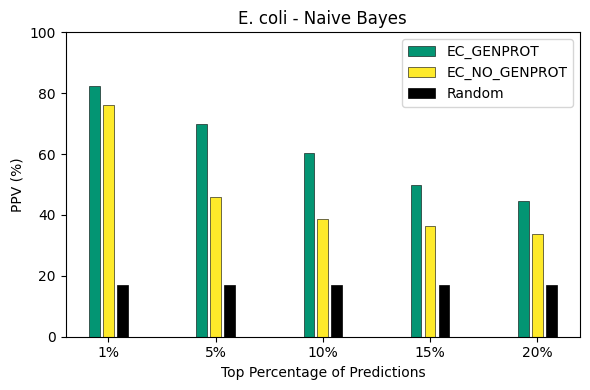

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
EC_GENPROT,0.82,0.7,0.6,0.5,0.45,3
EC_NO_GENPROT,0.76,0.46,0.39,0.36,0.34,3


In [96]:
classifier_genprot_nb = EssentiallyBayesClassifier('assets/coli_data.xls', CIMIM_EC_GENPROT, PERCENTILES, name='EC_GENPROT')
classifier_no_genprot_nb = EssentiallyBayesClassifier('assets/coli_data.xls', CIMIM_EC_NO_GENPROT, PERCENTILES, name='EC_NO_GENPROT')

experiment = EssentialityExperiment("E. coli - Naive Bayes", [classifier_genprot_nb, classifier_no_genprot_nb])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS[1:])
experiment.plot_and_save_comparative_table(colors=COLORS[1:])

### Running the Experiment with Random Forest Classifier for E. coli


--------------------------------------------------------------------------------
Running experiment for E. coli - Random Forest
Classifiers:  ['EC_GENPROT', 'EC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier EC_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Essential genes: 611 Non-essential genes: 2958 Essential ratio: 0.17119641356122164
Starting to find optimal number of features...
Features: 28, PPV (1%): 0.7142857142857142, PPV (5%): 0.6971428571428572
Features: 27, PPV (1%): 0.7428571428571429, PPV (5%): 0.6742857142857143
Features: 26, PPV (1%): 0.7142857142857143, PPV (5%): 0.6914285714285715
Features: 25, PPV (1%): 0.6857142857142857, PPV (5%): 0.6571428571428573
Features: 24, PPV (1%): 0.7142857142857142, PPV (5%): 0.6685714285714286
Features: 23, PPV (1%): 0.8, PPV (5%): 0.6971428571428572
Features: 22, PPV (1%): 0.7714285714285715, PP

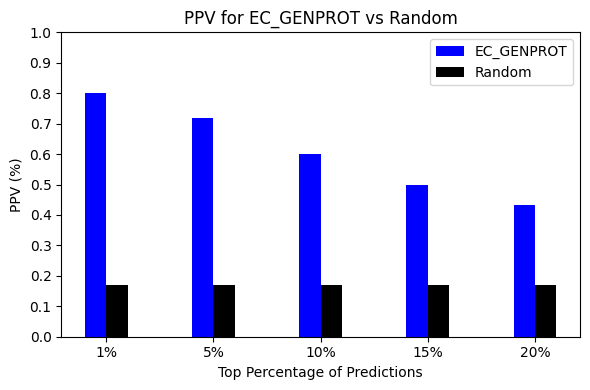

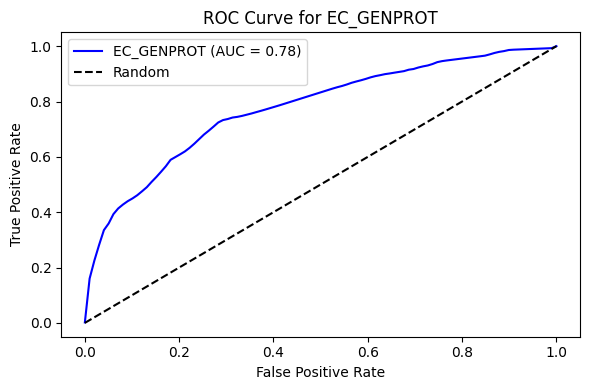

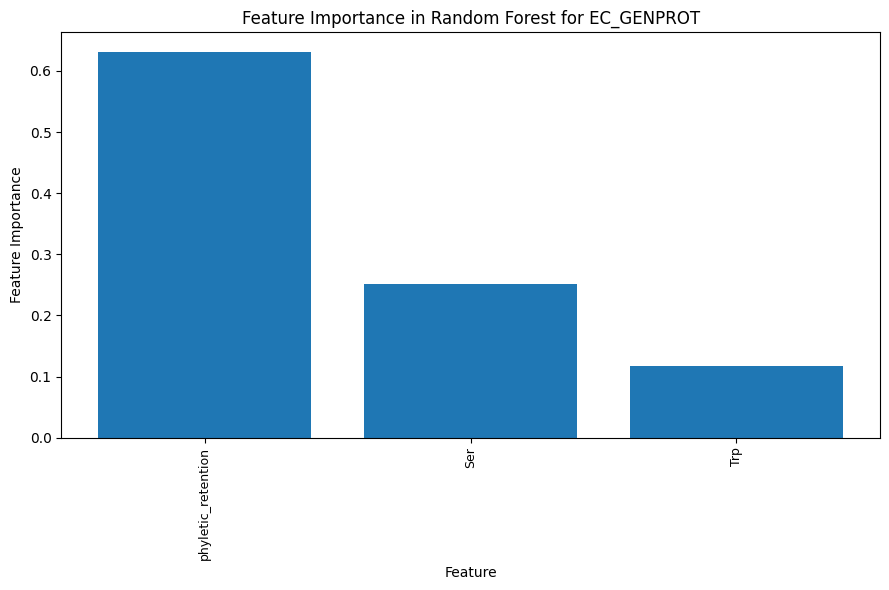

Running classifier EC_NO_GENPROT
--------------------------------------------------
Discretized data loaded successfully, shape: (3569, 28) (3569,)
Essential genes: 611 Non-essential genes: 2958 Essential ratio: 0.17119641356122164
Starting to find optimal number of features...
Features: 27, PPV (1%): 0.6857142857142857, PPV (5%): 0.44000000000000006
Features: 26, PPV (1%): 0.6571428571428571, PPV (5%): 0.4
Features: 25, PPV (1%): 0.7142857142857142, PPV (5%): 0.41142857142857137
Features: 24, PPV (1%): 0.6571428571428571, PPV (5%): 0.4057142857142857
Features: 23, PPV (1%): 0.6571428571428571, PPV (5%): 0.43428571428571433
Features: 22, PPV (1%): 0.6571428571428571, PPV (5%): 0.42857142857142855
Features: 21, PPV (1%): 0.6857142857142857, PPV (5%): 0.41142857142857137
Features: 20, PPV (1%): 0.7142857142857142, PPV (5%): 0.4057142857142857
Features: 19, PPV (1%): 0.6571428571428571, PPV (5%): 0.43428571428571433
Features: 18, PPV (1%): 0.6571428571428571, PPV (5%): 0.4342857142857143


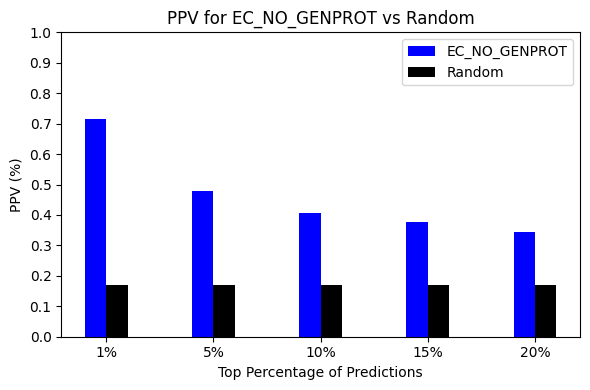

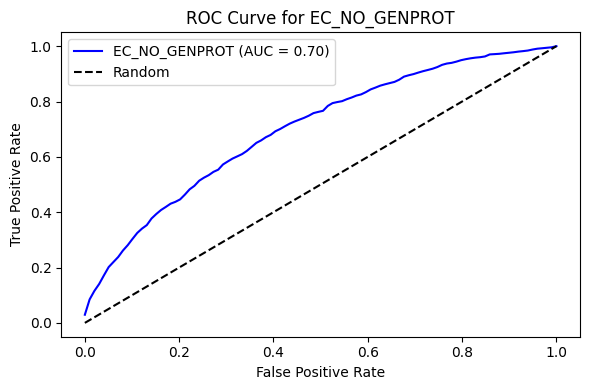

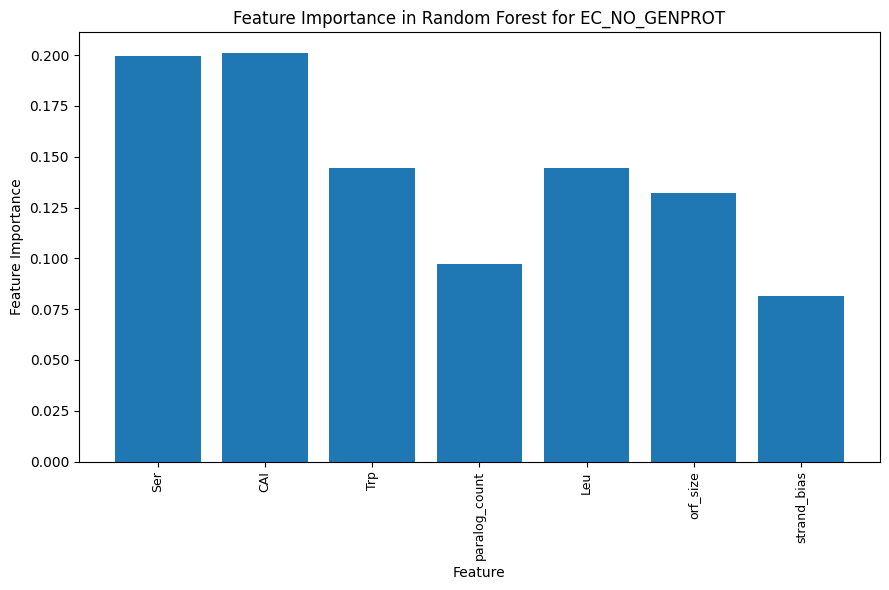

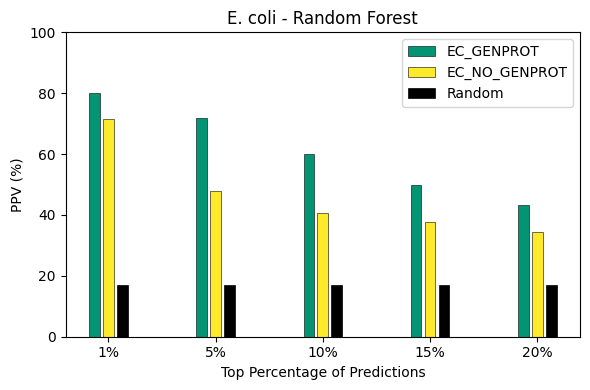

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
EC_GENPROT,0.8,0.72,0.6,0.5,0.43,3
EC_NO_GENPROT,0.71,0.48,0.41,0.38,0.35,7


In [99]:
classifier_genprot_rf = EssentialityRandomForestClassifier('assets/coli_data.xls', CIMIM_EC_GENPROT, PERCENTILES, name='EC_GENPROT')
classifier_no_genprot_rf = EssentialityRandomForestClassifier('assets/coli_data.xls', CIMIM_EC_NO_GENPROT, PERCENTILES, name='EC_NO_GENPROT')

experiment = EssentialityExperiment("E. coli - Random Forest", [classifier_genprot_rf, classifier_no_genprot_rf])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS[1:])
experiment.plot_and_save_comparative_table(colors=COLORS[1:])

### Compare ROC Curves of Naive Bayes and Random Forest for EC_GENPROT

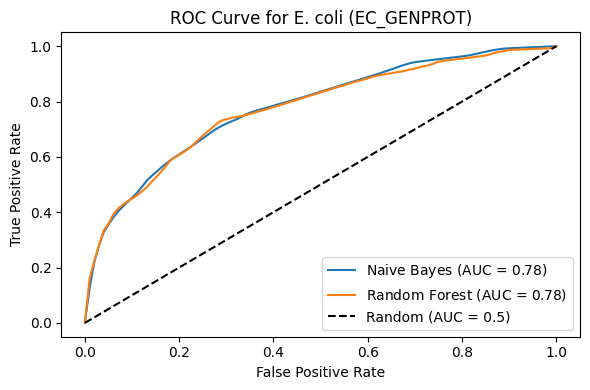

In [101]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(classifier_genprot_nb.final_fpr, classifier_genprot_nb.final_tpr, label='Naive Bayes (AUC = ${:.2f}$)'.format(classifier_genprot_nb.final_auc))
ax.plot(classifier_genprot_rf.final_fpr, classifier_genprot_rf.final_tpr, label='Random Forest (AUC = ${:.2f}$)'.format(classifier_genprot_rf.final_auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for E. coli (EC_GENPROT)')
ax.legend()
fig.tight_layout()


### Plotting ROC Curves for Paper Results

In this section, we plot the ROC curves for the results obtained by the authors of the paper *"Towards the Identification of Essential Genes Using Targeted Genome Sequencing and Comparative Analysis"* by Gustafson et al. (2006), using the Naive Bayes algorithm. The curves are calculated from the prediction results provided in the additional material of the paper and can be used as a benchmark to compare our results with those of the research article.


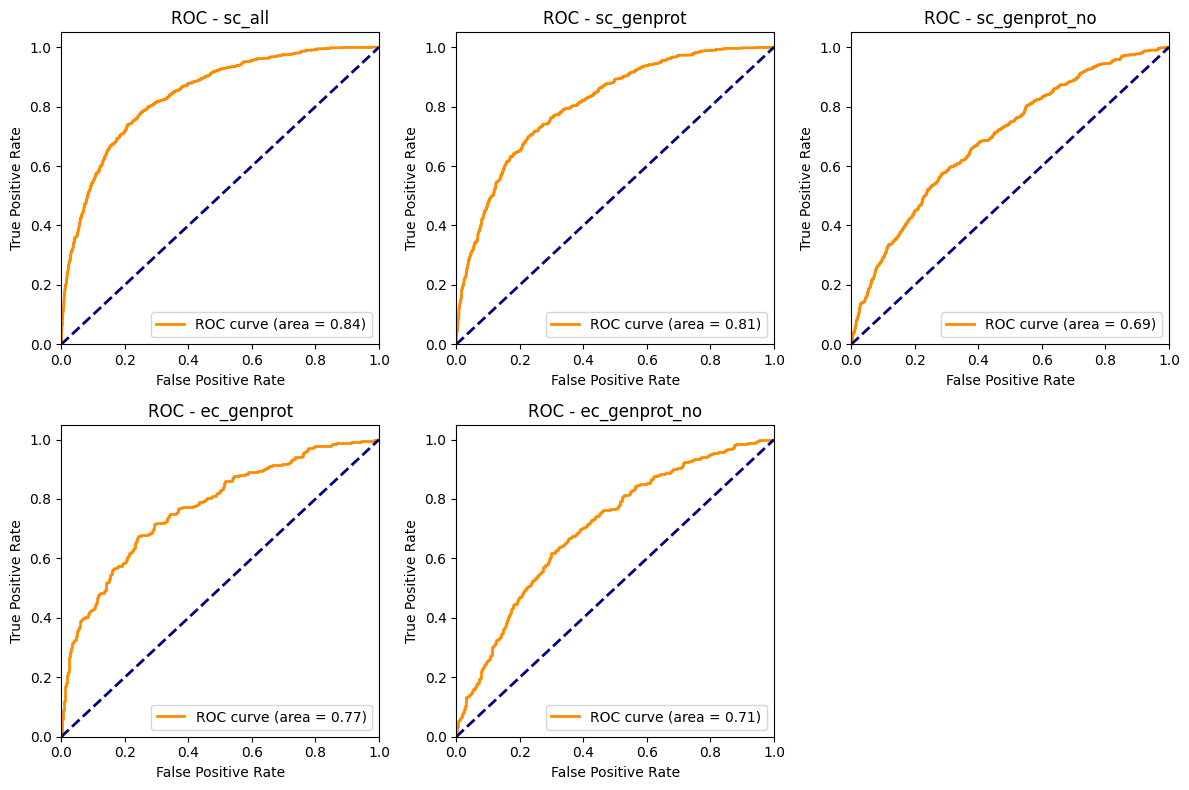

In [102]:
sheets = ["sc_all", "sc_genprot", "sc_genprot_no", "ec_genprot", "ec_genprot_no"]
file_path = 'assets/paper_results.xls'

num_sheets = len(sheets)
ncols = 3  
nrows = (num_sheets + ncols - 1) // ncols  

plt.figure(figsize=(12, 4 * nrows))

for i, sheet in enumerate(sheets):
    data = pd.read_excel(file_path, sheet_name=sheet)
    grand_truth = data[data.columns[1]]
    prediction = data[data.columns[2]]
    
    # ROC 
    fpr, tpr, thresholds = roc_curve(grand_truth, prediction)
    roc_auc = auc(fpr, tpr)
    
    # Add subplot   
    plt.subplot(nrows, ncols, i + 1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC - {sheet}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()